## Part 1

In [2]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import rank
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StringType, FloatType, DoubleType
from pyspark.sql.functions import monotonically_increasing_id
import os

appName = "project_checkpoint"
master = "local"

# Download and include the PostgreSQL JDBC driver
# !curl https://jdbc.postgresql.org/download/postgresql-42.7.4.jar --output postgresql-42.7.4.jar
# # Get the absolute path of the downloaded driver jar
# jdbc_driver_path = os.path.abspath("postgresql-42.7.4.jar")

#Create config object for spark
conf = pyspark.SparkConf()\
    .set('spark.driver.host', '127.0.0.1')\
    .set('spark.driver.memory', '5g')\
    .set('spark.executor.memory', '5g')\
    .setAppName(appName)\
    .setMaster(master) 
    # .set("spark.jars", jdbc_driver_path)

#Create spark context with new configs
sc = SparkContext.getOrCreate(conf=conf)

# Create sql context
sqlContext = SQLContext(sc)

# Create spark session
spark = sqlContext.sparkSession.builder.getOrCreate()


# List of dataset files and their corresponding year for later ingestion

files = [("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/female_players_16.csv", 2016), ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/female_players_17.csv", 2017),
         ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/female_players_18.csv", 2018), ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/female_players_19.csv", 2019),
         ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/female_players_20.csv", 2020), ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/female_players_21.csv", 2021),
         ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/female_players_22.csv", 2022),
         ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/players_15.csv", 2015), ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/players_16.csv", 2016),
         ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/players_17.csv", 2017), ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/players_18.csv", 2018),
         ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/players_19.csv", 2019), ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/players_20.csv", 2020),
         ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/players_21.csv", 2021), ("/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/players_22.csv", 2022)]

db_properties = {}
db_properties['username'] = "postgres"
db_properties['password'] = "dogs"


db_properties['url'] = "jdbc:postgresql://localhost:5432/postgres"
db_properties['driver'] = "org.postgresql.Driver"
db_properties['table'] = "fifa.players"

# Generate a master schema from one of the datasets to use for all of the
# datasets, to maintain consistency across different datasets

ref_file = "/Users/nicolevillavicencio/Documents/school/masters/Sys_and_Tools/project/fifa/players_22.csv"

ref_df = spark.read.csv(ref_file, header = True, inferSchema = True)
ref_columns = list(ref_df.columns)
ref_schema = ref_df.schema
ref_df.printSchema()

c:\Users\ez242\Documents\Anaconda\envs\14763\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: date (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_id: integer (nullable = true)
 

In [3]:
combined_df = None

for (file, year) in files:
    df = spark.read.csv(file, header = True, schema = ref_schema).toDF(*ref_columns)

    # Adding column for the year of the Fifa version
    df = df.withColumn("year", lit(year))
    if "female" in file:
        df = df.withColumn("gender", lit('female'))
    else:
        df = df.withColumn("gender", lit('male'))

    if combined_df is None:
        combined_df = df
    else:
        combined_df = combined_df.union(df)


    combined_df.write.format("jdbc")\
    .mode("overwrite")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .save()

combined_df = combined_df.withColumn("unique_id", monotonically_increasing_id())

combined_df.read = sqlContext.read.format("jdbc")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.load()

#### Section A: 

In [5]:
#combined_df.read.show(10, vertical = True)
combined_df.filter(F.col('year') == 2021).show()

+---------+--------------------+-------------+--------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+------------+---------+-----------+------------+-------------+------------------+----------------+-----------+-------------------------+--------------+----------------+--------------+---------------+--------------------+--------------+---------+-----------+------------------------+-------------+----------------+---------+------------------+--------------------+--------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+

In [6]:
# For analysis in Tasks 2 and 3, we only want to use the male player data
# due to missing and NAN values in female player data.

analysis_df = combined_df.filter(F.col('gender') == 'male')
analysis_df.show()

+---------+--------------------+-----------------+--------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+------------+-------------------+--------------------+------------+-------------+------------------+----------------+-----------+-------------------------+--------------+----------------+--------------+---------------+--------------------+--------------+---------+-----------+------------------------+-------------+----------------+---------+------------------+--------------------+--------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-

## Part 2

In [7]:
def clubs_with_most_contracts(df, X, Y, Z):
   # X: (int) desired year to query, must be between 2015 and 2022 inclusive
   # Y: (int) Number of clubs desired, should be greater than 0
   # Z: (int) year of contract end, must be 2023 or after
   # In Year X, what were the Y clubs that had the highest number of players with
   # contracts ending in year Z (or after)?

   if not (2015 <= X <= 2022):
      raise ValueError(f"Invalid: Year {X} is not in range 2015 to 2022")
   if not (Y > 0):
      raise ValueError(f"Invalid: Number of clubs must be greater than 0")
   if not (Z >= 2023):
      raise ValueError(f"Invalid: Contract termination year must be 2023 or after")

   filtered_df_x = df.filter(F.col('year') == X)

   filtered_df_z = filtered_df_x.filter(F.col('club_contract_valid_until') >= Z)

   filtered_df_y = filtered_df_z.groupBy("club_name").agg(F.count('*').alias('count'))
   window = Window.orderBy(F.desc('count'))
   df_ranked = filtered_df_y.withColumn('rank', F.row_number().over(window))
   df_most_contracts = df_ranked.filter(F.col('rank') <= Y).drop('rank')

   return df_most_contracts

df_most_contracts = clubs_with_most_contracts(analysis_df, 2022, 3, 2023)
df_most_contracts.show(3, vertical = True)


-RECORD 0-------------------------
 club_name | Leeds United         
 count     | 29                   
-RECORD 1-------------------------
 club_name | Sevilla FC           
 count     | 29                   
-RECORD 2-------------------------
 club_name | Borussia Möncheng... 
 count     | 27                   



In [8]:

def club_average_player_age(df, X, Y, highest = True):
   # X: (int) Number of clubs that you want to return, should be > 0
   # Y: (int) representing a year between 2015 and 2022, inclusive
   # List the X clubs with the highest (or lowest) average player age for a given
   # year Y.

   if not (X > 0):
      raise ValueError(f"Invalid number of clubs {X}, must be greater than 0")
   if not (2015 <= Y <= 2022):
      raise ValueError(f"Invalid: Year {Y} is not in range 2015 to 2022")

   filtered_df = df.filter(F.col('year') == Y)

   avg_age_df = filtered_df.groupBy("club_name").agg(F.avg("age").alias("avg_age"))

   if highest:
      window_spec = Window.orderBy(F.desc('avg_age'))
   else:
      window_spec = Window.orderBy(F.asc('avg_age'))

   df_ranked = avg_age_df.withColumn('rank', F.rank().over(window_spec))

   Xth_rank_value = df_ranked.filter(df_ranked['rank'] == X).select('avg_age').first()

   if Xth_rank_value:
      Xth_avg_age = Xth_rank_value['avg_age']

      # filter clubs with rank <= X or that share Xth rank's avg_age
      final_df = df_ranked.filter(
         (df_ranked['rank'] <= X) |
         (df_ranked['avg_age'] == Xth_avg_age)
      ).orderBy('rank')
   else:
      return "No clubs found for the given year"

   return final_df

avg_ages = club_average_player_age(analysis_df, 3, 2022, highest = False)
avg_ages.show()


+---------------+------------------+----+
|      club_name|           avg_age|rank|
+---------------+------------------+----+
|FC Nordsjælland|20.115384615384617|   1|
| SC Freiburg II|20.857142857142858|   2|
|Real Sociedad B|             21.16|   3|
+---------------+------------------+----+



In [9]:
def most_popular_nationality(df):
    # What is the most popular nationality in the dataset for each year? (i.e.
    # display the most frequent nation for 2015, 2016, etc.).

    df_grouped = df.groupBy('year', 'nationality_name').agg(F.count('*').alias('count'))

    window = Window.partitionBy('year').orderBy(F.desc('count'))

    df_ranked = df_grouped.withColumn('rank', F.row_number().over(window))

    df_most_popular = df_ranked.filter(F.col('rank') == 1).drop('rank')

    return df_most_popular

df_most_popular_nationalities = most_popular_nationality(analysis_df)
df_most_popular_nationalities.show(8, vertical = True)


-RECORD 0-------------------
 year             | 2015    
 nationality_name | England 
 count            | 1627    
-RECORD 1-------------------
 year             | 2016    
 nationality_name | England 
 count            | 1519    
-RECORD 2-------------------
 year             | 2017    
 nationality_name | England 
 count            | 1627    
-RECORD 3-------------------
 year             | 2018    
 nationality_name | England 
 count            | 1633    
-RECORD 4-------------------
 year             | 2019    
 nationality_name | England 
 count            | 1625    
-RECORD 5-------------------
 year             | 2020    
 nationality_name | England 
 count            | 1670    
-RECORD 6-------------------
 year             | 2021    
 nationality_name | England 
 count            | 1685    
-RECORD 7-------------------
 year             | 2022    
 nationality_name | England 
 count            | 1719    



## Part 3


#### Section B:

In [10]:
# Dropping unneccessary columns
df = combined_df

df = df.drop('gender','player_url', 'dob', 'club_team_id', 'club_jersey_number', 
             'club_loaned_from', 'nation_jersey_number', 'real_face', 
             'player_face_url', 'club_logo_url', 'club_flag_url', 
             'nation_logo_url', 'nation_flag_url')


In [11]:
# Turning our club_joined column (which is of a date datatype) into a timestamp to be able to properly run it through the pipeline later.
from pyspark.sql.functions import unix_timestamp

df = df.withColumn('club_joined', unix_timestamp('club_joined'))

In [12]:
# These columns have "+" characters which will not be processed through our pipeline, so we will be changing those now
for col in ['ls', 'st', 'rs', 'lam', 'cam', 'ram',  'lm', 'lcm',  'cm', 'rcm', 
            'rm', 'lwb', 'ldm', 'cdm', 'rdm','rwb', 'lb', 'lcb', 'cb', 'rcb', 
            'rb', 'gk']:
    df = df.withColumn(
        col,
        (F.split(F.col(col), '\\+')[0].cast('int') +
         F.split(F.col(col), '\\+')[1].cast('int')).cast('int')
    )

In [13]:
# Converting columns with numbers from string to integers
columns_to_convert = ['lw', 'lf', 'cf', 'rf', 'rw']

for col in columns_to_convert:
    df = df.withColumn(col, df[col].cast('int'))


In [14]:
# Handling NULL values
from pyspark.sql.functions import *

# Checking where we have null values
null_counts_plays_df = df.select([
    count(when(col(c).isNull(), c)).alias(c) if dict(df.dtypes)[c] not in ['double', 'float']
    else count(when(isnan(c) | col(c).isNull(), c)).alias(c)
    for c in df.columns
])

null_counts_plays_df.show(truncate=False, vertical=True)

-RECORD 0-----------------------------
 sofifa_id                   | 0      
 short_name                  | 0      
 long_name                   | 0      
 player_positions            | 0      
 overall                     | 0      
 potential                   | 0      
 value_eur                   | 4095   
 wage_eur                    | 3820   
 age                         | 0      
 height_cm                   | 0      
 weight_kg                   | 0      
 club_name                   | 3874   
 league_name                 | 3874   
 league_level                | 4259   
 club_position               | 3874   
 club_joined                 | 12179  
 club_contract_valid_until   | 3874   
 nationality_id              | 0      
 nationality_name            | 0      
 nation_team_id              | 133635 
 nation_position             | 133635 
 preferred_foot              | 0      
 weak_foot                   | 0      
 skill_moves                 | 0      
 international_reputation

There are various columns with null values, some ranging from having 61 null values all the way to 18,480 null values. Therefore, for the ones with minimal null values, we can drop– specically if it is less than 6% of the data. The rest we will calculate data.


In [15]:
# Dropping columns with minimal null values

casted_types_df = df

# Drop rows with null values
def drop_nulls_in_columns(df: DataFrame, columns: list) -> DataFrame:
    filter_condition = None
    for column in columns:
        if filter_condition is None:
            filter_condition = df[column].isNotNull()
        else:
            filter_condition = filter_condition & df[column].isNotNull()

    df_dropped = df.filter(filter_condition)
    return df_dropped


no_null_df = drop_nulls_in_columns(casted_types_df, ["value_eur", "wage_eur", 
                                                     "club_name", "league_name", 
                                                     "league_level", 
                                                     "club_position", 
                                                     "club_contract_valid_until", 
                                                     "club_joined", 
                                                     "release_clause_eur"])

# Also going ahead and dropping columns with nearly 80% or more of their rows being null
no_null_df = no_null_df.drop('nation_team_id', 'nation_position', 'player_tags', 'goalkeeping_speed')


# Re-showing the null values to make sure our function worked
null_counts_plays_df = no_null_df.select([
    count(when(col(c).isNull(), c)).alias(c) if dict(no_null_df.dtypes)[c] not in ['double', 'float']
    else count(when(isnan(c) | col(c).isNull(), c)).alias(c)
    for c in no_null_df.columns
])

null_counts_plays_df.show(truncate=False, vertical=True)

-RECORD 0----------------------------
 sofifa_id                   | 0     
 short_name                  | 0     
 long_name                   | 0     
 player_positions            | 0     
 overall                     | 0     
 potential                   | 0     
 value_eur                   | 0     
 wage_eur                    | 0     
 age                         | 0     
 height_cm                   | 0     
 weight_kg                   | 0     
 club_name                   | 0     
 league_name                 | 0     
 league_level                | 0     
 club_position               | 0     
 club_joined                 | 0     
 club_contract_valid_until   | 0     
 nationality_id              | 0     
 nationality_name            | 0     
 preferred_foot              | 0     
 weak_foot                   | 0     
 skill_moves                 | 0     
 international_reputation    | 0     
 work_rate                   | 0     
 body_type                   | 0     
 release_cla

In [16]:
# Focusing on filing in the rest of the null values.

from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.ml.feature import Imputer

def imputation(df: DataFrame, columns: list, missing_value: str = "NULL") -> DataFrame:

    df_result = no_null_df
    for column in columns:
        # Replace missing_value with None
        df_result = df_result.withColumn(column,
                           F.when(F.col(column) == missing_value, None)
                           .otherwise(F.col(column)))

        # Check if the column is numeric or categorical
        if df_result.schema[column].dataType.typeName() in ['integer', 'double', 'float']:
            # Fill nulls w -1 for numeric columns
            df_filled = df_result.fillna(-1, [column])

            # Create an Imputer to replace -1 with the median
            imputer = Imputer(
                inputCols=[column],
                outputCols=[f"{column}_imputed"]
            ).setStrategy("median").setMissingValue(-1)
            df_imputed = imputer.fit(df_filled).transform(df_filled)

            # Drop og columns and rename w imputed column
            df_result = df_imputed.drop(column).withColumnRenamed(f"{column}_imputed", column)

        else:
            # For string columns, fill nulls with "Unknown"
            df_result = df_result.fillna("Unknown", [column])

    return df_result

columns_to_impute = ["player_traits", "pace", "shooting", "passing", "dribbling", 
                     "defending", "physic", "mentality_composure", 'lw', 'lf', 
                     'cf', 'rf', 'rw','ls', 'st', 'rs', 'lam', 'cam', 'ram',  
                     'lm', 'lcm',  'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 
                     'rdm','rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']
imputed_df = imputation(no_null_df, columns_to_impute)

In [17]:
# Checking to make sure there are no more NULL values.
null_counts_plays_df = imputed_df.select([
    count(when(col(c).isNull(), c)).alias(c) if dict(imputed_df.dtypes)[c] not in ['double', 'float']
    else count(when(isnan(c) | col(c).isNull(), c)).alias(c)
    for c in imputed_df.columns
])

null_counts_plays_df.show(truncate=False, vertical=True)

-RECORD 0--------------------------
 sofifa_id                   | 0   
 short_name                  | 0   
 long_name                   | 0   
 player_positions            | 0   
 overall                     | 0   
 potential                   | 0   
 value_eur                   | 0   
 wage_eur                    | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 club_name                   | 0   
 league_name                 | 0   
 league_level                | 0   
 club_position               | 0   
 club_joined                 | 0   
 club_contract_valid_until   | 0   
 nationality_id              | 0   
 nationality_name            | 0   
 preferred_foot              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 work_rate                   | 0   
 body_type                   | 0   
 release_clause_eur          | 0   
 player_traits              

We have officially cleaned our data.

#### Section C

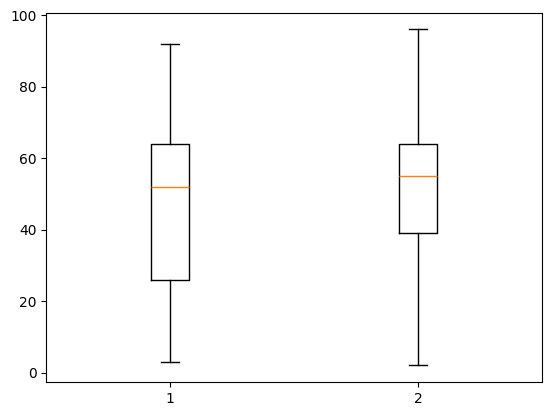

In [18]:
# Checking to if we have any outliers in our dataframe.
import matplotlib.pyplot as plt

numeric_features = [feature[0] for feature in imputed_df.dtypes if feature[1] in ('int','double')]

spotted_data = imputed_df[numeric_features[36:38]].toPandas()
figure_subset = plt.boxplot(spotted_data)

There are no outliers in the dataset. Lets check for correlation

In [19]:
import pandas as pd

# Converting PySpark df to a Pandas df just to see correlation (as shown in lectures 6 & 7)
pandas_df = imputed_df.toPandas()

numeric_df = pandas_df.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()
print(correlation_matrix)

           sofifa_id   overall  potential  value_eur  wage_eur       age  \
sofifa_id   1.000000 -0.450225   0.008633  -0.120987 -0.235875 -0.714167   
overall    -0.450225  1.000000   0.659771   0.583538  0.591105  0.471753   
potential   0.008633  0.659771   1.000000   0.554075  0.500520 -0.233847   
value_eur  -0.120987  0.583538   0.554075   1.000000  0.818386  0.062012   
wage_eur   -0.235875  0.591105   0.500520   0.818386  1.000000  0.159836   
...              ...       ...        ...        ...       ...       ...   
lcb        -0.135931  0.393171   0.247796   0.205986  0.224763  0.159313   
cb         -0.135931  0.393171   0.247796   0.205986  0.224763  0.159313   
rcb        -0.135931  0.393171   0.247796   0.205986  0.224763  0.159313   
rb         -0.125199  0.432929   0.285530   0.239198  0.252957  0.149536   
gk         -0.130426  0.047711  -0.007256   0.018820  0.014553  0.142892   

           height_cm  weight_kg  league_level  club_joined  ...       ldm  \
sofifa_id 

In [20]:
# Using Spark df now and dropping columns with high correlation
df_with_handled_correlations = imputed_df\
                .drop("cb","wage_eur")

Here I am organizing the column into their data types, like binary, continuous, etc. Also replacing the original preferred_foot column with its binary encoded replacement.
I'll also omit many of the columns in the continuous columns list, in order to prevent making the model overly complex and also because many of the additional attirbutes seem unrelated or too unique to specific positions or players, and are not relevant for all players.

In [21]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

binary_cols = ['preferred_foot']
continuous_cols = ['year', 'potential', 'value_eur', 'age', 'height_cm', 'weight_kg', 'league_level', 'skill_moves', 'international_reputation', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
                #    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'rwb', 'rwb', 'rwb', 'lb', 'lcb', 'rcb', 'rb', 'gk']
nominal_cols = ['short_name', 'long_name', 'player_positions', 'league_name', 'club_name', 'club_position', 'nationality_name', 'weak_foot', 'work_rate', 'body_type', 'player_traits']
ordinal_cols = ['club_position', 'work_rate', 'body_type']
cols_to_drop = ['club_joined', 'club_contract_valid_until', 'nationality_id', 'release_clause_eur',]

# Handling binary variables
df_with_handled_binary = (df_with_handled_correlations
    .withColumn("preferred_foot_encoded",
                F.when(F.lower(df_with_handled_correlations["preferred_foot"]) == "right", 1)
                 .when(F.lower(df_with_handled_correlations["preferred_foot"]) == "left", 0)
                 .otherwise(None)))  # Handle unexpected values if needed

df_with_handled_binary.select("preferred_foot", "preferred_foot_encoded").distinct().show()


+--------------+----------------------+
|preferred_foot|preferred_foot_encoded|
+--------------+----------------------+
|         Right|                     1|
|          Left|                     0|
+--------------+----------------------+



#### Section D

In [22]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType


# Define your columns
binary_cols = ['preferred_foot_encoded']
ordinal_cols = ['club_position', 'work_rate', 'body_type']
nominal_cols = ['short_name', 'long_name', 
                'player_positions', 'league_name', 
                'club_name', 'nationality_name', 'weak_foot', 'player_traits']

class FeatureTypeCaster(Transformer):  # This transformer will cast the columns as appropriate types
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols:
            output_df = output_df.withColumn(col_name, col(col_name).cast(IntegerType()))
        for col_name in ordinal_cols:
            output_df = output_df.withColumn(col_name, col(col_name).cast("string"))
        return output_df

class ColumnDropper(Transformer):  # This transformer drops unnecessary columns
    def __init__(self, columns_to_drop=None):
        super().__init__()
        self.columns_to_drop = columns_to_drop

    def _transform(self, dataset):
        return dataset.drop(*self.columns_to_drop)

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset.withColumn('outcome', col('overall').cast(DoubleType()))
        return output_df


def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where ordinal columns are transformed to index columns using StringIndexer
    ordinal_id_cols = [x + "_index" for x in ordinal_cols]
    ordinal_onehot_cols = [x + "_encoded" for x in ordinal_cols]

    stage_ordinal_indexer = StringIndexer(inputCols=ordinal_cols, outputCols=ordinal_id_cols)

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_ordinal_onehot_encoder = OneHotEncoder(inputCols=ordinal_id_cols, outputCols=ordinal_onehot_cols)

    # Combine all OHE columns for vector assembly
    feature_cols = (ordinal_onehot_cols + 
                    binary_cols +
                    continuous_cols)     
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')

    # Stage for creating the outcome column vector representing the predicted overall value
    stage_outcome = OutcomeCreater()
    outcome_assembler = VectorAssembler(inputCols=['outcome'], outputCol='outcome_vector')

    # Removing all unnecessary columns, keeping only 'features'
    stage_column_dropper = ColumnDropper(columns_to_drop=nominal_cols + 
                                          ordinal_cols + ordinal_id_cols +
                                          ordinal_onehot_cols + binary_cols + 
                                          ['vectorized_features'] + continuous_cols
                                          + cols_to_drop) 

    # Connect the stages into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,
                                 stage_ordinal_indexer,
                                 stage_ordinal_onehot_encoder,
                                 stage_vector_assembler,
                                 stage_scaler,
                                 stage_outcome,
                                 outcome_assembler,
                                 stage_column_dropper])
    return pipeline


### Here we split our overall dataset into two distinct partitions: the training set which is 80% of the dataset, and the test dataset which is the remaining 20%. The dataset was split randomly

In [23]:
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Splitting data
fifa_train, fifa_test = df_with_handled_binary.randomSplit([0.8, 0.2], seed=42)

print("Train data count:", fifa_train.count())
print("Test data count:", fifa_test.count())


Train data count: 69108
Test data count: 17004


In [24]:
print(df_with_handled_binary)

DataFrame[sofifa_id: int, short_name: string, long_name: string, player_positions: string, overall: int, potential: int, value_eur: double, age: int, height_cm: int, weight_kg: int, club_name: string, league_name: string, league_level: int, club_position: string, club_joined: bigint, club_contract_valid_until: int, nationality_id: int, nationality_name: string, preferred_foot: string, weak_foot: int, skill_moves: int, international_reputation: int, work_rate: string, body_type: string, release_clause_eur: int, player_traits: string, attacking_crossing: int, attacking_finishing: int, attacking_heading_accuracy: int, attacking_short_passing: int, attacking_volleys: int, skill_dribbling: int, skill_curve: int, skill_fk_accuracy: int, skill_long_passing: int, skill_ball_control: int, movement_acceleration: int, movement_sprint_speed: int, movement_agility: int, movement_reactions: int, movement_balance: int, power_shot_power: int, power_jumping: int, power_stamina: int, power_strength: int

In [25]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(fifa_train)

fifa_df = preprocess_pipeline_model.transform(fifa_train)
fifa_df_test = preprocess_pipeline_model.transform(fifa_test)

## Part 4


Spark ML Model: For our first spark ML model, we will use Linear Regression - because we are trying to predict the overall value of the players based on their attributes, we felt that using linear regression would be a good fit. We will calculate the accuracy of the model based on the average percent difference between the predictions and the actual overall value of each player

In [ ]:
# Linear Regression Model

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol = 'outcome')

lrModel = lr.fit(fifa_df) 

lr_predictions = lrModel.transform(fifa_df_test)

# Printing accuracy

lr_predictions_train = lrModel.transform(fifa_df)# predictions using the training dataset

# Compute the percentage difference between 'overall' and 'prediction'
lr_predictions_train = lr_predictions_train.withColumn(
    "percent_difference", 
    abs(col("overall") - col("prediction")) / col("overall")
)

# Calculate the average percentage difference (accuracy metric)
lr_accuracy_train = lr_predictions_train.select(mean("percent_difference")).first()[0]
print(f"Train Accuracy: {np.round((1 - lr_accuracy_train) * 100, 2)}%")

lr_predictions = lrModel.transform(fifa_df_test)

lr_predictions = lr_predictions.withColumn(
    "percent_difference", 
    abs(col("overall") - col("prediction")) / col("overall")
)

# Calculate the average percentage difference (accuracy metric)
lr_accuracy_test = lr_predictions.select(mean("percent_difference")).first()[0]
print(f"Test Accuracy: {np.round((1 - lr_accuracy_test) * 100, 2)}%")


Train Accuracy: 97.45%
Test Accuracy: 97.44%


In [27]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, abs, mean

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='outcome')

# Fit the model on the training dataset
lrModel = lr.fit(fifa_df)

# Make predictions on the training dataset
lr_predictions_train = lrModel.transform(fifa_df)

# Make predictions on the test dataset
lr_predictions_test = lrModel.transform(fifa_df_test)

# Initialize the evaluator with MSE as the metric
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="mse")

# Calculate MSE for training data
train_mse = evaluator.evaluate(lr_predictions_train)
print(f"Train MSE: {train_mse}")

# Calculate MSE for test data
test_mse = evaluator.evaluate(lr_predictions_test)
print(f"Test MSE: {test_mse}")


Train MSE: 4.4824024152610775
Test MSE: 4.515320964548305


As we can see, the linear regression model performed very well on both the train and test datasets, with over 90% accuracy, and relatively low train and test MSE. Let's continue and try to apply hyperparameter tuning through cross validation to see if we can achieve even better accuracies. The hyperparameters that I will be tuning are the regularization parameter and the maximum number of iterations of the model. I chose a range of values that I felt would give us a diverse set of models while still solving in a reasonable amount of time

In [28]:
# Linear Regression Model 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol = 'features', labelCol = 'outcome')

# Create ParamGrid for Cross Validation
lr_paramGrid = (ParamGridBuilder() 
                .addGrid(lr.regParam, [0.01, 0.5, 1.0]) 
                .addGrid(lr.maxIter, [1, 5, 10]) 
                .build()) 

lr_model = lr.fit(fifa_df)
lr_predictions_train = lr_model.transform(fifa_df)
lr_predictions_test = lr_model.transform(fifa_df_test)

# Evaluatation 
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="mse") 

# Create cross-validation tuning 
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, evaluator=evaluator, numFolds=5) 
lr_cv_model = lr_cv.fit(fifa_df) 
lr_cv_predictions_train = lr_cv_model.transform(fifa_df) 
MSE_train = evaluator.evaluate(lr_cv_predictions_train) 
lr_cv_predictions_test = lr_cv_model.transform(fifa_df_test)
MSE_test = evaluator.evaluate(lr_cv_predictions_test)

print("Train MSE before Cross-Validation: ", evaluator.evaluate(lr_predictions_train))
print("Train MSE after Cross-Validation: ", MSE_train)
print("Test MSE before Cross-Validation: ", evaluator.evaluate(lr_predictions_test))
print("Test MSE after Cross-Validation: ", MSE_test)


Train MSE before Cross-Validation:  4.4824024152610775
Train MSE after Cross-Validation:  4.485708099367197
Test MSE before Cross-Validation:  4.515320964548305
Test MSE after Cross-Validation:  4.521656028885142


In [29]:
# Retrieve the best model from cross-validation
best_lr_model = lr_cv_model.bestModel

# Use the best model to make predictions on test data
best_model_predictions_test = best_lr_model.transform(fifa_df_test)
best_MSE_test = evaluator.evaluate(best_model_predictions_test)

# Print out the parameters of the best model
print("Best model parameters:")
print(" - regParam:", best_lr_model._java_obj.getRegParam())
print(" - maxIter:", best_lr_model._java_obj.getMaxIter())

# Display MSE for the best model on test data
print("Test MSE for the best model:", best_MSE_test)


Best model parameters:
 - regParam: 0.01
 - maxIter: 1
Test MSE for the best model: 4.521656028885142


As we can see, our cross validation models did not perform much better than our original model configuration, although the MSE is still relatively low and we have already achieved a high accuracy on the train and test datasets. For that reason we will continue with our original linear regression model as our best model.

In [30]:
lr_predictions.select('outcome','prediction','overall').show()

+-------+-----------------+-------+
|outcome|       prediction|overall|
+-------+-----------------+-------+
|   65.0|66.59081270978899|     65|
|   75.0|73.98448043278859|     75|
|   77.0|76.69934308077697|     77|
|   58.0|64.83158373899082|     58|
|   77.0|78.36905957563087|     77|
|   83.0| 81.2038287153253|     83|
|   70.0|73.97009910764683|     70|
|   88.0|90.82842730677964|     88|
|   69.0|73.15518467004307|     69|
|   62.0|65.00196451713902|     62|
|   63.0|69.67677602529173|     63|
|   70.0|75.42394768895753|     70|
|   83.0|85.10325534484738|     83|
|   69.0| 74.3496571428224|     69|
|   80.0|80.13765779040665|     80|
|   59.0|62.54480724010776|     59|
|   64.0|66.97017948554668|     64|
|   64.0|68.18576778806371|     64|
|   60.0|66.04762579861233|     60|
|   68.0|70.31995174866734|     68|
+-------+-----------------+-------+
only showing top 20 rows



#### Section E

In [31]:
# Random Forest Regressor Model

from pyspark.ml.regression import RandomForestRegressor

rfg = RandomForestRegressor(featuresCol='features', labelCol='overall', numTrees=100)

rfModel = rfg.fit(fifa_df)

rf_predictions = rfModel.transform(fifa_df_test)

In [46]:
# Printing accuracy

rf_predictions_train = rfModel.transform(fifa_df)# predictions using the training dataset

# Compute the percentage difference between 'overall' and 'prediction'
rf_predictions_train = rf_predictions_train.withColumn(
    "percent_difference", 
    abs(col("overall") - col("prediction")) / col("overall")
)

# Calculate the average percentage difference (accuracy metric)
rf_accuracy_train = rf_predictions_train.select(mean("percent_difference")).first()[0]
print(f"Train Accuracy: {np.round((1 - rf_accuracy_train) * 100, 2)}%")

rf_predictions = rf_predictions.withColumn(
    "percent_difference", 
    abs(col("overall") - col("prediction")) / col("overall")
)

# Calculate the average percentage difference (accuracy metric)
rf_accuracy_test = rf_predictions.select(mean("percent_difference")).first()[0]
print(f"Test Accuracy: {np.round((1 - rf_accuracy_test) * 100, 2)}%")

print("Test MSE for the best model:", evaluator.evaluate(rf_predictions))


Train Accuracy: 97.97%
Test Accuracy: 97.99%
Test MSE for the best model: 3.104730448971209


In [33]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import abs, col, mean
import numpy as np

# Define Random Forest model
rf = RandomForestRegressor(featuresCol='features', labelCol='outcome')

# Define hyperparameter grid for cross-validation
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [5, 10, 15])         # Test different numbers of trees
             .addGrid(rf.maxDepth, [3, 5, 10])           # Test different max depth values
             .build())

# Define evaluator for cross-validation (using MSE as metric)
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="mse")

# Set up cross-validation
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Fit cross-validation model
cvModel = cv.fit(fifa_df)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Evaluate on the training dataset
rf_predictions_train = bestModel.transform(fifa_df)

# Compute percentage difference for training accuracy
rf_predictions_train = rf_predictions_train.withColumn(
    "percent_difference",
    abs(col("overall") - col("prediction")) / col("overall")
)

# Calculate training accuracy
rf_accuracy_train = rf_predictions_train.select(mean("percent_difference")).first()[0]
print(f"Train Accuracy after Cross-Validation: {np.round((1 - rf_accuracy_train) * 100, 2)}%")

# Evaluate on the test dataset
rf_predictions_test = bestModel.transform(fifa_df_test)

# Compute percentage difference for test accuracy
rf_predictions_test = rf_predictions_test.withColumn(
    "percent_difference",
    abs(col("overall") - col("prediction")) / col("overall")
)

# Calculate test accuracy
rf_accuracy_test = rf_predictions_test.select(mean("percent_difference")).first()[0]
print(f"Test Accuracy after Cross-Validation: {np.round((1 - rf_accuracy_test) * 100, 2)}%")

# Print the best hyperparameters
print(f"Best numTrees: {bestModel.getNumTrees}")
print(f"Best maxDepth: {bestModel.getOrDefault('maxDepth')}")


Train Accuracy after Cross-Validation: 99.09%
Test Accuracy after Cross-Validation: 99.06%
Best numTrees: 15
Best maxDepth: 10


In [45]:
print("Test MSE for the best model:", evaluator.evaluate(rf_predictions_test))

Test MSE for the best model: 0.6637530273408097


As you can see, our cross validation hyperparameter tuning allowed us to achieve a higher accuracy with the specific configuration of 15 trees and max depth of 10, giving us an accuracy of 99.06% on the test dataset and an MSE of 0.6637, which is higher than the 97.99% accuracy and 3.10 MSE on test data that we achieved with our original model. Our best model configuration then is the random forest regressor with numTrees = 15 and maxDepth = 10

## Part 5

Now, I will move on to doing ML modeling using tensorflow specifically using Multi-Layer Perceptrons and Convolutional Neural Networks. I chose to use neural network models because of their versatility and ability to model complex relationships to high degrees of accuracy. I will start with the MultiLayer Perceptron, which I configured to have 4 layers, with decreasing number of neurons in each layer and a ReLU activation. This will be my initial model 

In [34]:
# Converting PySpark df to Pandas df so we can use it in Tensorflow
import numpy as np

fifa_train_pd = fifa_df.toPandas()
fifa_test_pd = fifa_df_test.toPandas()

# Separate features and target in the data
X_train = np.array([np.array(row) for row in fifa_train_pd['features']])
y_train = fifa_train_pd['overall'].values

X_test = np.array([np.array(row) for row in fifa_test_pd['features']])
y_test = fifa_test_pd['overall'].values


#### Section F

In [ ]:
# MLP

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  
])

mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# TRrain
mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Mean absolute error to compare
mlp_loss, mlp_mae = mlp_model.evaluate(X_test, y_test)
print("MLP Test MAE: ", mlp_mae)


c:\Users\ez242\Documents\Anaconda\envs\14763\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 207.9867 - mae: 7.3074 - val_loss: 17.5100 - val_mae: 3.2175
Epoch 2/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 15.5433 - mae: 3.0807 - val_loss: 13.3809 - val_mae: 2.7587
Epoch 3/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.8528 - mae: 2.4102 - val_loss: 7.9845 - val_mae: 2.1608
Epoch 4/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.5407 - mae: 2.1200 - val_loss: 5.2966 - val_mae: 1.7289
Epoch 5/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.5102 - mae: 1.9660 - val_loss: 4.4777 - val_mae: 1.6075
Epoch 6/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.8521 - mae: 1.8710 - val_loss: 4.2665 - val_mae: 1.5591
Epoch 7/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.9298 - mae: 1.7202 - val_loss: 5.3951 - val_mae: 1.7770
Epoch 8/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.5153 - mae: 1.6452 - val_loss: 3.3162 - val_mae: 1.4277
Epoch 9/50
1728/1728 ━━━━━━━━━━━━━━

In [48]:

# Calculate the percentage difference for accuracy on test data
y_pred_test = mlp_model.predict(X_test).flatten()  # Flatten to match y_test shape

percent_differences = np.abs((y_test - y_pred_test) / y_test)
test_accuracy = 1 - np.mean(percent_differences)  # Average accuracy over all test samples
print(f"Test Accuracy: {np.round(test_accuracy * 100, 2)}%")


532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 96.91%


Our initial MLP model performed quite well, with an average MAE Test loss of 1.5, and a test accuracy of 96.91%. Now I will apply hyperparameter tuning through cross validation to see if I can find a better model. The hyperparameters I will be tuning are the size of the layers and number of neurons as well as the learning rate.

In [36]:

# MLP cross validation hyperparameter tuning
# Source: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam

# Define hyperparameter grids
layer_configs = [(8, 4, 2), (4, 2)]
learning_rates = [0.01, 0.1]

# Dictionary to store the results
tuning_results = {}

# Cross-validation for each combination of layer config and learning rate
for layers in layer_configs:
    for lr in learning_rates:
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        mae_scores = []

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Define model with current hyperparameters
            mlp_model = Sequential()
            for units in layers:
                mlp_model.add(Dense(units, activation='relu'))
            mlp_model.add(Dense(1))  # Output layer
            
            optimizer = Adam(learning_rate=lr)
            mlp_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

            # Train
            mlp_model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)

            # Evaluate on the validation fold
            _, mae = mlp_model.evaluate(X_val_fold, y_val_fold, verbose=0)
            mae_scores.append(mae)

        # Store the average MAE for each combination
        avg_mae = np.mean(mae_scores)
        tuning_results[(layers, lr)] = avg_mae
        print(f"Layer configuration: {layers}, Learning Rate: {lr} - Average MAE: {avg_mae}")

# Manually find the best configuration based on MAE
best_config, best_mae = None, float('inf')

for config, mae in tuning_results.items():
    if mae < best_mae:
        best_config = config
        best_mae = mae

# Display the best configuration and its MAE
print("\nBest configuration:")
print("Layers:", best_config[0])
print("Learning Rate:", best_config[1])
print("Average MAE for best configuration:", best_mae)


Layer configuration: (8, 4, 2), Learning Rate: 0.01 - Average MAE: 5.551881154378255
Layer configuration: (8, 4, 2), Learning Rate: 0.1 - Average MAE: 3.027750333150228
Layer configuration: (4, 2), Learning Rate: 0.01 - Average MAE: 5.549846490224202
Layer configuration: (4, 2), Learning Rate: 0.1 - Average MAE: 4.381831407546997

Best configuration:
Layers: (8, 4, 2)
Learning Rate: 0.1
Average MAE for best configuration: 3.027750333150228


In [50]:
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.metrics import r2_score

# Extract best layer configuration and learning rate
best_layers, best_lr = best_config

# Define and compile the best model
best_model = Sequential()
for units in best_layers:
    best_model.add(Dense(units, activation='relu'))
best_model.add(Dense(1))  # Output layer

optimizer = Adam(learning_rate=best_lr)
best_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train the best model on the full training set
best_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Evaluate the model on the test set
mse_metric = MeanSquaredError()
test_predictions = best_model.predict(X_test)
mse_metric.update_state(y_test, test_predictions)
test_mse = mse_metric.result().numpy()

# Calculate MAE and accuracy
test_mae = np.mean(np.abs(test_predictions - y_test))

# Calculate R-squared as an accuracy measure
test_r2 = r2_score(y_test, test_predictions)

print("\nBest Model Results on Test Data:")
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test R-squared (Accuracy):", test_r2)


532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Best Model Results on Test Data:
Test MSE: 49.436073
Test MAE: 5.564043294960009
Test R-squared (Accuracy): -3.6954879760742188e-06


Unfortunately the models from our cross-validation did not perform as well as our initial MLP model, with the best MLP model configuration only giving us a MAE of 5.564 on the test dataset, which is much worse than the test MAE of 1.5 from our original model. For that reason we will be using our original MLP model as our best model.

#### Section G

Now, I will move onto our second model in TensorFlow, which will be using a Convolutional Neural Network. I will see if this configuration performs better than my MLP model. I will use 4 hidden layers and ReLU activation, so that I have a relatively deep model. ReLU is also a good choice in general for activation functions, especially in possible nonlinear cases. 

In [38]:
# CNN

X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)  # Reshape for 1D convolution
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

cnn_model = Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train 
cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Mean absolute error to compare
cnn_loss, cnn_mae = cnn_model.evaluate(X_test_cnn, y_test)
print("CNN Test MAE: ", cnn_mae)


Epoch 1/50


c:\Users\ez242\Documents\Anaconda\envs\14763\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1728/1728 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 152.4855 - mae: 7.5591 - val_loss: 53.3495 - val_mae: 5.8318
Epoch 2/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 48.8072 - mae: 5.5190 - val_loss: 44.7116 - val_mae: 5.2860
Epoch 3/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 46.7970 - mae: 5.4385 - val_loss: 33.1594 - val_mae: 4.6359
Epoch 4/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 32.4518 - mae: 4.5669 - val_loss: 16.6399 - val_mae: 3.3137
Epoch 5/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 13.7994 - mae: 2.8962 - val_loss: 3.4401 - val_mae: 1.3915
Epoch 6/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.0046 - mae: 1.5246 - val_loss: 4.0962 - val_mae: 1.5610
Epoch 7/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 3.4445 - mae: 1.4204 - val_loss: 2.4046 - val_mae: 1.1942
Epoch 8/50
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.9935 - mae: 1.3151 - val_loss: 3.7701 - val_mae: 1.6250
Epoch 9/50
1728/1728 ━━━━━━━━━━━━━━━━━

Our convolutional neural network model works quite well, with a test MAE of 0.909. I will again implement hyperparameter tuning through cross validation to see if I can further improve the accuracy of our model. The hyperparameters I will tune are the configurations of the layers, both number of layers and the number of neurons, as well as the learning rates.

In [39]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

# Reshape for 1D convolution
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# Define hyperparameter grids
filter_configs = [(8, 4, 2), (4, 2)]
learning_rates = [0.01, 0.1]

# Dictionary to store results
cnn_tuning_results = {}

# Cross-validation for each combination of filters and learning rate
for filters in filter_configs:
    for lr in learning_rates:
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        mae_scores = []

        for train_index, val_index in kf.split(X_train_cnn):
            X_train_fold, X_val_fold = X_train_cnn[train_index], X_train_cnn[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Define CNN model with current hyperparameters
            cnn_model = Sequential([
                Conv1D(filters=filters[0], kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
                MaxPooling1D(pool_size=2),
                Conv1D(filters=filters[1], kernel_size=3, activation='relu'),
                GlobalAveragePooling1D(),
                Dense(32, activation='relu'),
                Dense(1)
            ])
            
            optimizer = Adam(learning_rate=lr)
            cnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

            # Train
            cnn_model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)

            # Evaluate on the validation fold
            _, mae = cnn_model.evaluate(X_val_fold, y_val_fold, verbose=0)
            mae_scores.append(mae)

        # Store the average MAE for each combination
        avg_mae = np.mean(mae_scores)
        cnn_tuning_results[(filters, lr)] = avg_mae
        print(f"Filters: {filters}, Learning Rate: {lr} - Average MAE: {avg_mae}")

# Manually find the best configuration based on MAE
best_config, best_mae = None, float('inf')

for config, mae in cnn_tuning_results.items():
    if mae < best_mae:
        best_config = config
        best_mae = mae

# Display the best configuration and its MAE
print("\nBest configuration:")
print("Layers:", best_config[0])
print("Learning Rate:", best_config[1])
print("Average MAE for best configuration:", best_mae)


Filters: (8, 4, 2), Learning Rate: 0.01 - Average MAE: 2.9929938316345215
Filters: (8, 4, 2), Learning Rate: 0.1 - Average MAE: 4.4789369106292725
Filters: (4, 2), Learning Rate: 0.01 - Average MAE: 3.2684048811594644
Filters: (4, 2), Learning Rate: 0.1 - Average MAE: 4.887560606002808

Best configuration:
Layers: (8, 4, 2)
Learning Rate: 0.01
Average MAE for best configuration: 2.9929938316345215


In [52]:
# Recreate the best CNN model with optimal hyperparameters
best_filters, best_lr = best_config
best_cnn_model = Sequential([
    Conv1D(filters=best_filters[0], kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=best_filters[1], kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile with the best learning rate
best_optimizer = Adam(learning_rate=best_lr)
best_cnn_model.compile(optimizer=best_optimizer, loss='mse', metrics=['mae'])

# Train the best model on the entire training dataset
best_cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, verbose=0)

# Evaluate on the test dataset
test_loss, test_mae = best_cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test MSE: {test_loss}")
print(f"Test MAE: {test_mae}")

# Calculate the percentage difference for accuracy on test data
y_pred_test = best_cnn_model.predict(X_test_cnn).flatten()  # Flatten to match y_test shape

percent_differences = np.abs((y_test - y_pred_test) / y_test)
test_accuracy = 1 - np.mean(percent_differences)  # Average accuracy over all test samples
print(f"Test Accuracy: {np.round(test_accuracy * 100, 2)}%")


c:\Users\ez242\Documents\Anaconda\envs\14763\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test MSE: 2.9650251865386963
Test MAE: 1.3853319883346558
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 97.86%


As we can see, my convolutional neural networks from cross validation did not perform as well as my original configuration. The best model was only able to achieve a test MAE of 2.152 compared to 0.909 for my original model. I will use our original model as the best model moving forward.